In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import glob
import os
import csv
import sys

filename = "torqueTrackLog.csv";
tempfile_path = os.path.join(os.getcwd(), 'temp')

def write_debug_file():
    try:
        df.to_csv('debug.csv', sep=';', index=False)
    except:
        print('\nDebug saving failed:', sys.exc_info()[0])
    

with open(filename, encoding='UTF-8') as f:
        chunks = re.finditer(r'(GPS Time.*?)(?=GPS Time)', f.read(), re.S | re.M)        
        
        if not os.path.exists(tempfile_path):
            os.mkdir(tempfile_path)
        
        for i, chunk in enumerate(chunks, 1):
            with open(os.path.join(tempfile_path, '%s.csv' %i), 'w', encoding='UTF-8', newline='') as outfile:
                outfile.write(chunk.group(1))
                              
            
df = pd.DataFrame()
for file in glob.glob(os.path.join(tempfile_path, '*.csv')):
    print('Reading... ' + file)
    df_temp = pd.read_csv(file, sep=';', header=0) 
    
    if(df_temp.columns.size == 1):
        print('Only one column found. File seems not \';\'-separated. Trying \',\' ...')
        df_temp = pd.read_csv(file, sep=',', header=0)
        
    print(f"Found {df_temp.size} rows and {df_temp.columns.size} columns")
    
    if (df.empty):
        df = df_temp
    else:      
        df = pd.concat([df, df_temp], sort=False)
    os.remove(os.path.join(tempfile_path, file))    
    
df = df.reset_index(drop=True)
             
print(f"\nDataframe size is {df.size} x {df_temp.columns.size}")
write_debug_file()

Reading... C:\Users\Ville\Kaggle\Oma OBD reader\obd-analysis\temp\1.csv
Only one column found. File seems not ';'-separated. Trying ',' ...
Found 113951 rows and 17 columns

Dataframe size is 113951 x 17


In [13]:
print(f"\nDataframe size is {df.size} x {df_temp.columns.size}")
#print(df.head())
#print(df.index)
print(df.columns)
print(df.dtypes)

dataframe size is 113951
Index(['GPS Time', ' Device Time', ' Longitude', ' Latitude',
       'GPS Speed (Meters/second)', ' Horizontal Dilution of Precision',
       ' Altitude', ' Bearing', ' G(x)', ' G(y)', ' G(z)', ' G(calibrated)',
       'Engine Coolant Temperature(°C)', 'Fuel pressure(kPa)',
       'Engine RPM(rpm)', 'Timing Advance(°)',
       'Throttle Position(Manifold)(%)'],
      dtype='object')
GPS Time                              object
 Device Time                          object
 Longitude                           float64
 Latitude                            float64
GPS Speed (Meters/second)            float64
 Horizontal Dilution of Precision    float64
 Altitude                            float64
 Bearing                             float64
 G(x)                                float64
 G(y)                                float64
 G(z)                                float64
 G(calibrated)                       float64
Engine Coolant Temperature(°C)        object
Fuel

In [14]:
def to_date_or_none(var, strformat):
    if(isinstance(var, datetime.datetime)):
        return var
    
    try:
        datevar = datetime.datetime.strptime(var, strformat)
        return datevar
    except:
        return pd.to_datetime(None)


df[[' Device Time']] = df[[' Device Time']].applymap(lambda x : to_date_or_none(x,'%d-%b-%Y %H:%M:%S.%f'))
df[['GPS Time']] = df[['GPS Time']].applymap(lambda x : to_date_or_none(x,'%a %b %d %H:%M:%S %Z%z %Y'))
df = df.replace('-', '')

columns = df.columns
df[columns[2:]] = df[columns[2:]].apply(pd.to_numeric, errors='coerce')

print(df.dtypes)


GPS Time                             datetime64[ns, GMT]
 Device Time                              datetime64[ns]
 Longitude                                       float64
 Latitude                                        float64
GPS Speed (Meters/second)                        float64
 Horizontal Dilution of Precision                float64
 Altitude                                        float64
 Bearing                                         float64
 G(x)                                            float64
 G(y)                                            float64
 G(z)                                            float64
 G(calibrated)                                   float64
Engine Coolant Temperature(°C)                   float64
Fuel pressure(kPa)                               float64
Engine RPM(rpm)                                  float64
Timing Advance(°)                                float64
Throttle Position(Manifold)(%)                   float64
dtype: object


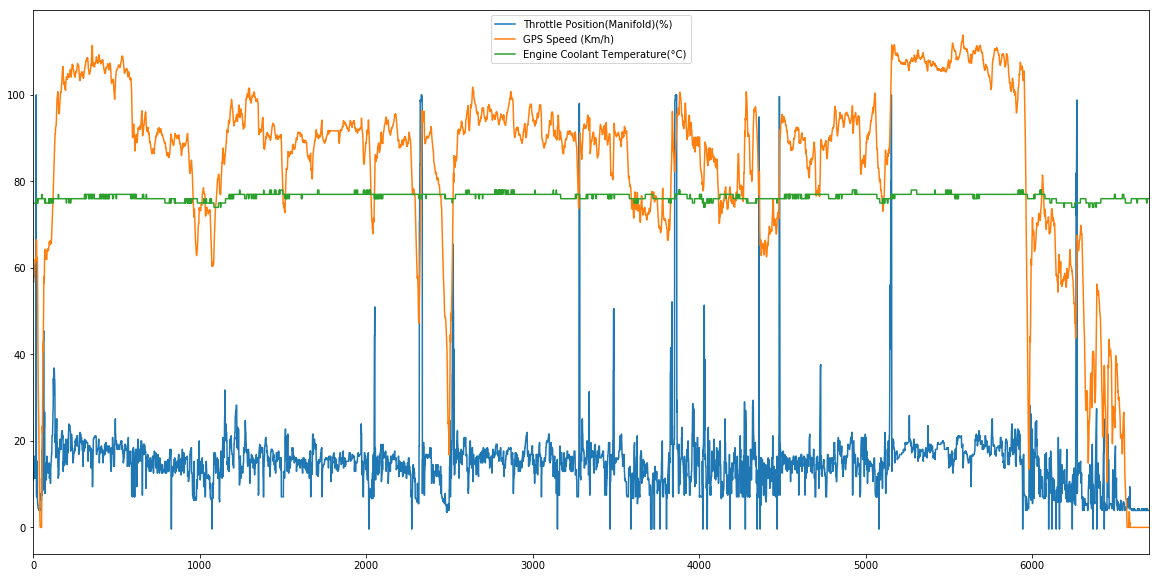

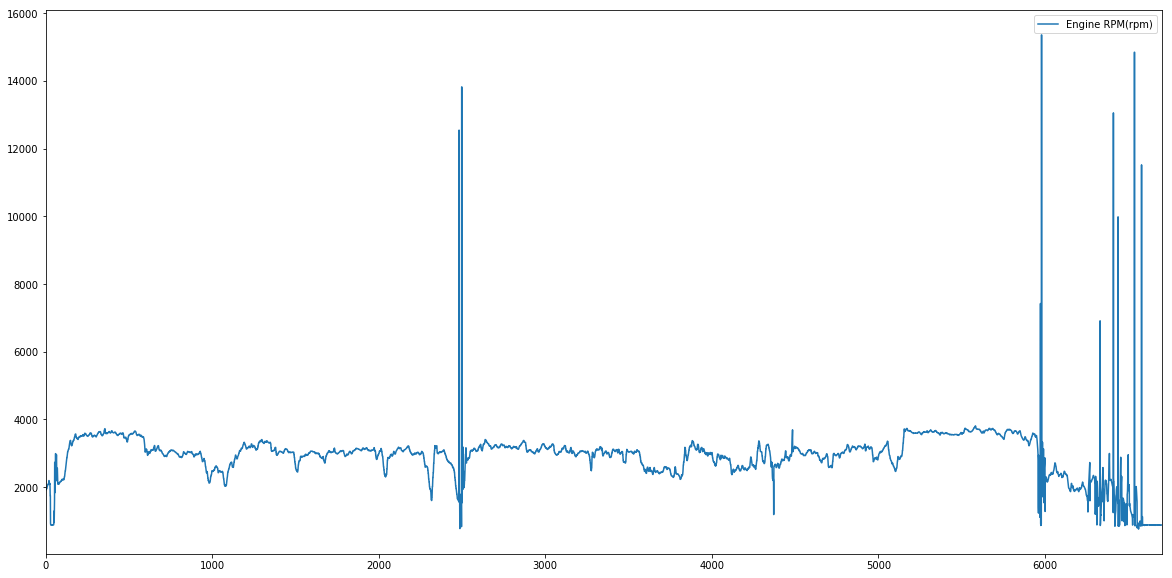

In [18]:
# Engine emperature, throttle position and speed
temp = df[['Throttle Position(Manifold)(%)', 'GPS Speed (Meters/second)', 'Engine Coolant Temperature(°C)']]
temp.loc[:, 'GPS Speed (Meters/second)'] = temp['GPS Speed (Meters/second)']*60*60/1000  # Change speed to km/h
temp = temp.rename(columns={'GPS Speed (Meters/second)': 'GPS Speed (Km/h)'})

temp.plot(kind='line', figsize=(20,10))
plt.show()

# RPM (different scale, different figure)
df[['Engine RPM(rpm)']].plot(kind='line', figsize=(20,10))
plt.show()


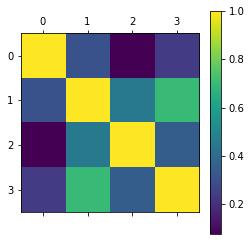

In [16]:

plt.matshow(df[['Throttle Position(Manifold)(%)', 'GPS Speed (Meters/second)', 'Engine Coolant Temperature(°C)', 
                 'Engine RPM(rpm)']].corr())
plt.colorbar()
plt.show()

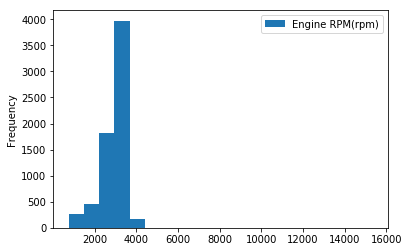

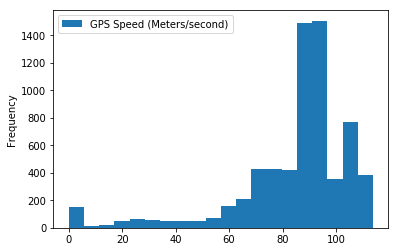

In [17]:
df[['Engine RPM(rpm)']].plot(kind='hist', bins=20)
plt.show()

temp = df[['GPS Speed (Meters/second)']]*60*60/1000
temp.plot(kind='hist', bins=20)
plt.show()